In [2]:
from IPython.display import IFrame
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc

from __future__ import print_function, unicode_literals
from builtins import open

from future import standard_library
standard_library.install_aliases()
import nibabel 

import nibabel as nib

import os
import urllib.request
import urllib.error
import urllib.parse
from nipype.interfaces.ants import Registration
import os
import sys 
sys.path.insert(0, '../../../antsbin')

import os
import numpy as np
from nibabel.testing import data_path

# Algorithm

## Description 

ANTs computes high-dimensional mappings to capture the statistics of brain structure and function (or at least that's what their website say)

**Inputs** 
1. fixed image
2. moving image
3. similarity metric 
4. metric weights 
5. transformation (e.g. SyN, affine, rigid, translation) 
6. shrink factors 
7. smoothing sigmas 

**Outputs** 
1. The transformed image

**Pseudocode** 

In [3]:
#![Neighborhood Density Filter Pseudocode](neighborhoodDensityPseudo.jpg)
IFrame("ANTS_nonlinear_pseudocode.pdf", width=600, height=600)

## Actual Code

In [ ]:
#Registration Inputs
reg = Registration()
reg.inputs.fixed_image = input_images[0]
reg.inputs.moving_image = input_images[1]
reg.inputs.metric = ['Mattes'] * 3 + [['Mattes', 'CC']]
reg.inputs.metric_weight = [1] * 3 + [[0.5, 0.5]]
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 + [[4, 2, 1]]
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]]
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine', 'SyN']

#Run ANTs
reg.run()

#Nifty File Conversion
example_filename = os.path.join(data_path, 'examplefile.nii.gz')
img = nib.load(example_filename)
img_data = img.get_data()

## Predicted Conditions 
ANTs will work well when the key features of an object to not change (i.e. a donut doesn't become a line). 

## Predictable Data Sets

**The Good Data Set:**

**Description:** The good data set is 2 100x100 volumes containing 3 clusters with value of 1. Every other value in the volume is 0. 

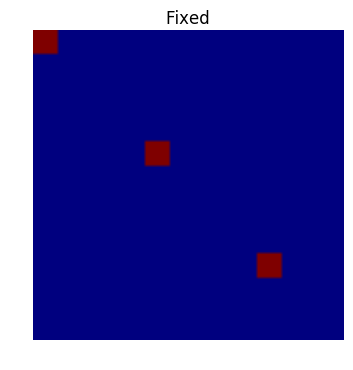

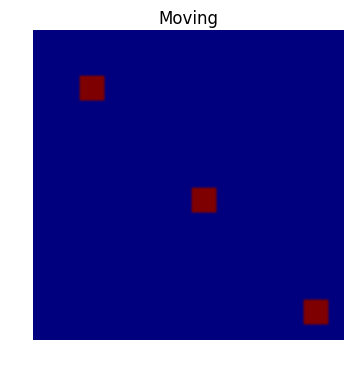

In [69]:
simEasyFixed = np.zeros((100, 100))
for i in range(4):
    for j in range(4):
        simEasyFixed[18*(2*j): 18*(2*j) + 8, 18*(2*j): 18*(2*j) + 8] = 1

simEasyMoving = np.zeros((100, 100))
for i in range(4):
    for j in range(4):
        simEasyMoving[18*(2*j) + 15: 18*(2*j + 1) + 5, 18*(2*j) + 15: 18*(2*j + 1) + 5] = 1
        
plt.imshow(simEasyFixed)
plt.axis('off')
plt.title('Fixed')
plt.show()

plt.imshow(simEasyMoving)
plt.axis('off')
plt.title('Moving')
plt.show()

**The Bad Data Set:**

**Description:** The bad data set is 2 100x100 volumes, one containing 2 clusters, one containing 3 with value of 1. Every other value in the volume is 0. 

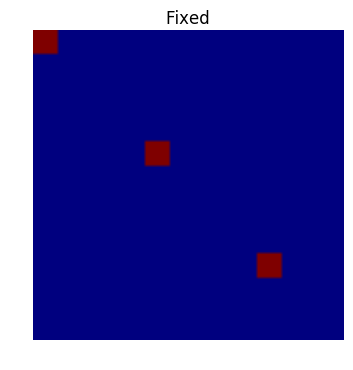

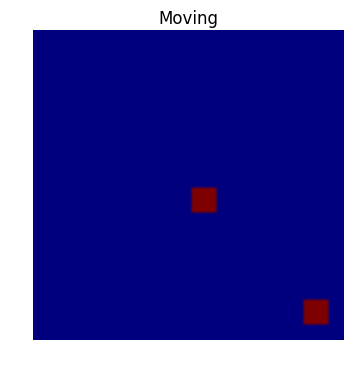

In [70]:
simBadFixed = np.zeros((100, 100))
for i in range(4):
    for j in range(4):
        simBadFixed[18*(2*j): 18*(2*j) + 8, 18*(2*j): 18*(2*j) + 8] = 1

simBadMoving = np.zeros((100, 100))
for i in range(1, 4):
    for j in range(1, 4):
        simBadMoving[18*(2*j) + 15: 18*(2*j + 1) + 5, 18*(2*j) + 15: 18*(2*j + 1) + 5] = 1
        
plt.imshow(simBadFixed)
plt.axis('off')
plt.title('Fixed')
plt.show()

plt.imshow(simBadMoving)
plt.axis('off')
plt.title('Moving')
plt.show()

### Toy Good Data Prediction
**Good Data Prediction: ** 
I predict that the good data will be perfectly aligned. 

In [71]:
scipy.misc.imsave('simEasyFixed.jpg', simEasyFixed)
scipy.misc.imsave('simEasyMoving.jpg', simEasyMoving)

In [136]:
reg = Registration()
reg.inputs.fixed_image = 'simEasyFixed.jpg'
reg.inputs.moving_image = 'simEasyMoving.jpg'
reg.inputs.output_warped_image = 'EASY_SIM.nii.gz'
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine', 'SyN']
reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)]
reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 4)
reg.inputs.dimension = 2
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.metric = ['Mattes'] * 3 + [['Mattes', 'CC']]
reg.inputs.metric_weight = [1] * 3 + [[0.5, 0.5]]
reg.inputs.radius_or_number_of_bins = [32] * 3 + [[32, 4]]
reg.inputs.sampling_strategy = ['Regular'] * 3 + [[None, None]]
reg.inputs.sampling_percentage = [0.3] * 3 + [[None, None]]
reg.inputs.convergence_threshold = [1.e-8] * 3 + [-0.000001]
reg.inputs.convergence_window_size = [20] * 3 + [5]
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]]
reg.inputs.sigma_units = ['vox'] * 4
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 + [[4, 2, 1]]
reg.inputs.use_estimate_learning_rate_once = [True] * 4
reg.inputs.use_histogram_matching = [False] * 3 + [True]
reg.inputs.initial_moving_transform_com = True

In [137]:
reg.run()

In [138]:
example_filename = os.path.join('EASY_SIM.nii.gz')
img = nib.load(example_filename)
easyImgData = img.get_data()

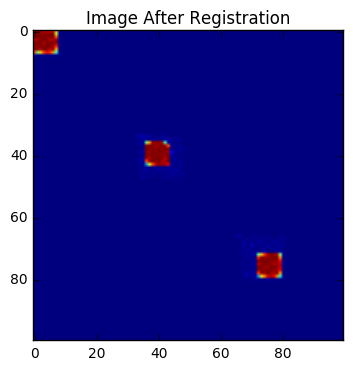

In [139]:
plt.imshow(easyImgData)
plt.title('Image After Registration')
plt.show()

## Easy Simulation Analysis

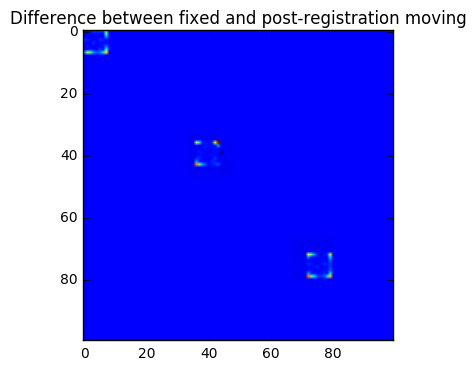

In [140]:
easyDifference = simEasyFixed - easyImgData/256
plt.imshow(easyDifference)
plt.title('Difference between fixed and post-registration moving')
plt.show()

As predicted, the data registered functionally perfectly. There are some boundary issues, but those are irrelevant to the problem we are trying solve. 

### Toy Bad Data Prediction
**Bad Data Prediction: ** 
I predict that the bad data will only register 2 of the clusters.

In [88]:
scipy.misc.imsave('simBadFixed.jpg', simBadFixed)
scipy.misc.imsave('simBadMoving.jpg', simBadMoving)

In [120]:
reg = Registration()
reg.inputs.fixed_image = 'simBadFixed.jpg'
reg.inputs.moving_image = 'simBadMoving.jpg'
reg.inputs.output_transform_prefix = 'thisTransform'
reg.inputs.output_warped_image = 'DIFF_SIM.nii.gz'
reg.inputs.output_transform_prefix = "output_"
reg.inputs.transforms = ['Translation', 'Rigid', 'Affine']
reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.1,)]
reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 3)
reg.inputs.dimension = 2
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.metric = ['MI'] * 3 
reg.inputs.metric_weight = [1] * 3 
reg.inputs.radius_or_number_of_bins = [32] * 3
reg.inputs.sampling_strategy = ['Regular'] * 3 
reg.inputs.sampling_percentage = [0.3] * 3 
reg.inputs.convergence_threshold = [1.e-8] * 3 
reg.inputs.convergence_window_size = [20] * 3 
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 3 
reg.inputs.sigma_units = ['vox'] * 3
reg.inputs.shrink_factors = [[6, 4, 2]] + [[3, 2, 1]] * 2 
reg.inputs.use_estimate_learning_rate_once = [True] * 3
reg.inputs.use_histogram_matching = [False] * 3 
reg.inputs.initial_moving_transform_com = True

In [121]:
reg.run()

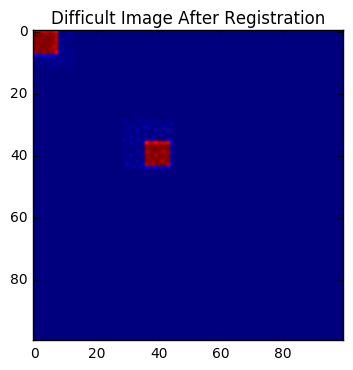

In [122]:
diff_sim_reg = os.path.join('DIFF_SIM.nii.gz')
img = nib.load(diff_sim_reg)
img_data_diff = img.get_data()
plt.imshow(img_data_diff)
plt.title('Difficult Image After Registration')
plt.show()

## Difficult Simulation Analysis

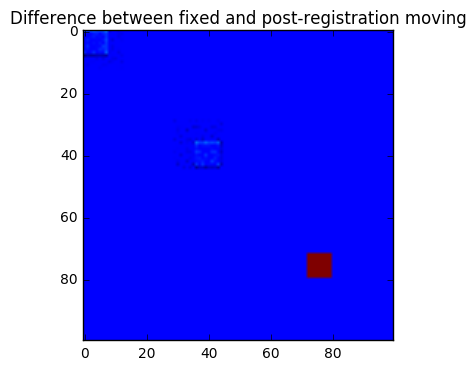

In [123]:
diffDifference = simBadFixed - img_data_diff/256
plt.imshow(diffDifference)
plt.title('Difference between fixed and post-registration moving')
plt.show()